<a href="https://colab.research.google.com/github/Nickjgniklu/FashionMnist/blob/main/FashionMnistTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolutional Neural Networks**



##**Imports and Load Data**

In [1]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

<module 'keras.api._v2.keras.datasets.fashion_mnist' from '/usr/local/lib/python3.7/dist-packages/keras/api/_v2/keras/datasets/fashion_mnist/__init__.py'>

## What's the data?



In [2]:
train_images.shape

(60000, 28, 28)

In [3]:
test_images.shape

(10000, 28, 28)

The pre trained model requires certain image sizes 96 by 96 is one

In [4]:
IMG_SIZE = (96, 96)
BATCH_SIZE = 100


In [5]:

print(train_images.shape)  
train_images = np.repeat(train_images[..., np.newaxis], 3, -1)
print(train_images.shape) 


(60000, 28, 28)
(60000, 28, 28, 3)


In [6]:
test_images = np.repeat(test_images[..., np.newaxis], 3, -1)


In [7]:
train_images=tf.image.resize(train_images,IMG_SIZE)
train_images.shape


TensorShape([60000, 96, 96, 3])

In [8]:
test_images=tf.image.resize(test_images,IMG_SIZE)
test_images.shape

TensorShape([10000, 96, 96, 3])

AttributeError: ignored

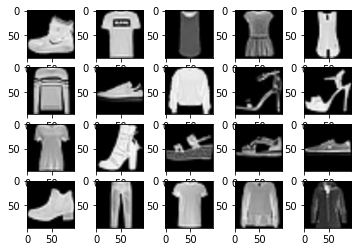

In [9]:
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(train_images[i].numpy().astype("uint8"))



In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

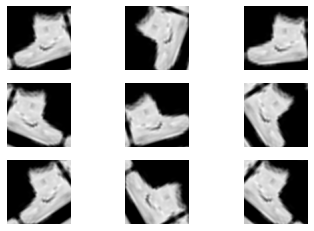

In [11]:

first_image = train_images[0]
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
  plt.imshow(augmented_image[0] / 255, cmap='gray')
  plt.axis('off')

##Reshape layers for this for mobilenet v2  This model expects pixel values in [-1, 1]

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [14]:
feature_batch = base_model(train_images[0].numpy().reshape((-1,96,96,3)))
print(feature_batch.shape)

(1, 3, 3, 1280)


In [15]:
train_images[0].numpy().reshape((-1,96,96,3)).shape

(1, 96, 96, 3)

In [16]:
  base_model.trainable = False


In [17]:
base_model.summary()


Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
________________________________________________________________________________

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(1, 1280)


In [19]:
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(1, 10)


In [20]:
inputs = tf.keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [22]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [23]:
loss0, accuracy0 = model.evaluate(test_images,test_labels)

313/313 [==============================] - 10s 26ms/step - loss: 10.4309 - accuracy: 0.0796


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 10.43
initial accuracy: 0.08


In [ ]:
history = model.fit(train_images,train_labels,
                    epochs=10,
                    validation_split=0.2)

In [ ]:
loss0, accuracy0 = model.evaluate(test_images,test_labels)

In [ ]:
print("final loss: {:.2f}".format(loss0))
print("final accuracy: {:.2f}".format(accuracy0))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()